# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

# Import libraries

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, skew, ttest_ind

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import shap

random_seed = 42

# Preparing the Data

In [2]:
df = pd.read_csv('recipe_site_traffic_2212.csv', index_col=0)
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


## Exploring the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


In [4]:
df.describe(include='all')

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,106,389,574
mean,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


In [5]:
df.isna().sum()/len(df)

calories        0.054910
carbohydrate    0.054910
sugar           0.054910
protein         0.054910
category        0.000000
servings        0.000000
high_traffic    0.393875
dtype: float64

In [6]:
for col in df.select_dtypes('object').columns:
    print(f'Unique values of column "{col}": {df[col].unique()}')

Unique values of column "category": ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
Unique values of column "servings": ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
Unique values of column "high_traffic": ['High' nan]


In [7]:
df[df['servings'].str.contains('snack')]['category'].unique()

array(['Lunch/Snacks'], dtype=object)

In [8]:
df.corr(numeric_only=True)

,calories,carbohydrate,sugar,protein
calories,1.000000,-0.028970,-0.097302,0.172477
carbohydrate,-0.028970,1.000000,0.073922,-0.042795
sugar,-0.097302,0.073922,1.000000,-0.099053
protein,0.172477,-0.042795,-0.099053,1.000000


### 🔍 Observations:
- calories, carbs, sugar & protein have all equal number of missing values, about 5.5%
- no high correlation in any of the dimensions (calories, carbs, sugar & protein)
- high_traffic has only 1 value 'High', rest is just nulls -> it might be mapped to bool
- high_traffic values (False & True) are not equal in size, ~39% False & ~61% True -> train & test split should be stratified
- even though servings seemed like numeric field, it is actually a dtype object (string), because some values contain text 'as a snack'
- looking on category of servings where servings contain 'snack' we can see that it is only included in 'Lunch/Snack', hence, we can split them based on the word 'snack' in servings

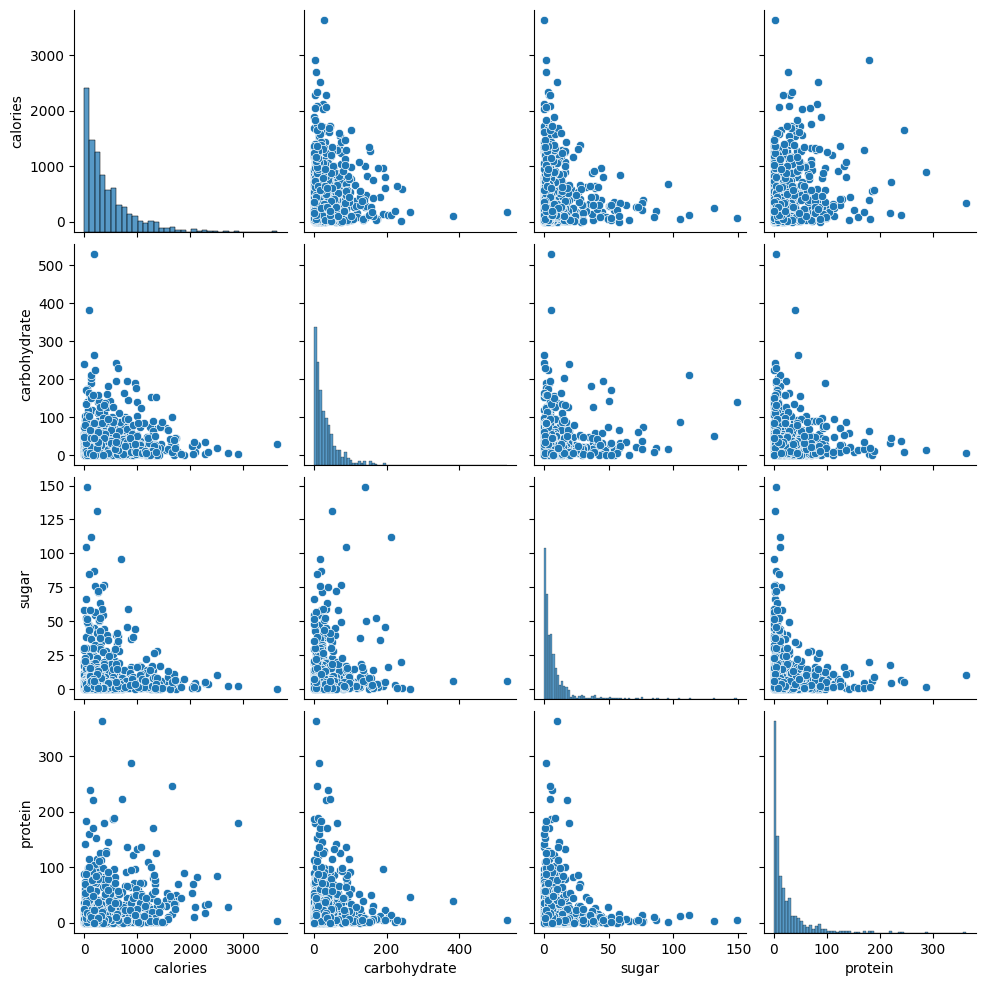

In [9]:
df_floats = df.select_dtypes('float')
sns.pairplot(df_floats)

### 🔍 Observations:
- all features are highly right-skewed, it needs some standardization, below is a pairplot with log normalization applied to the data

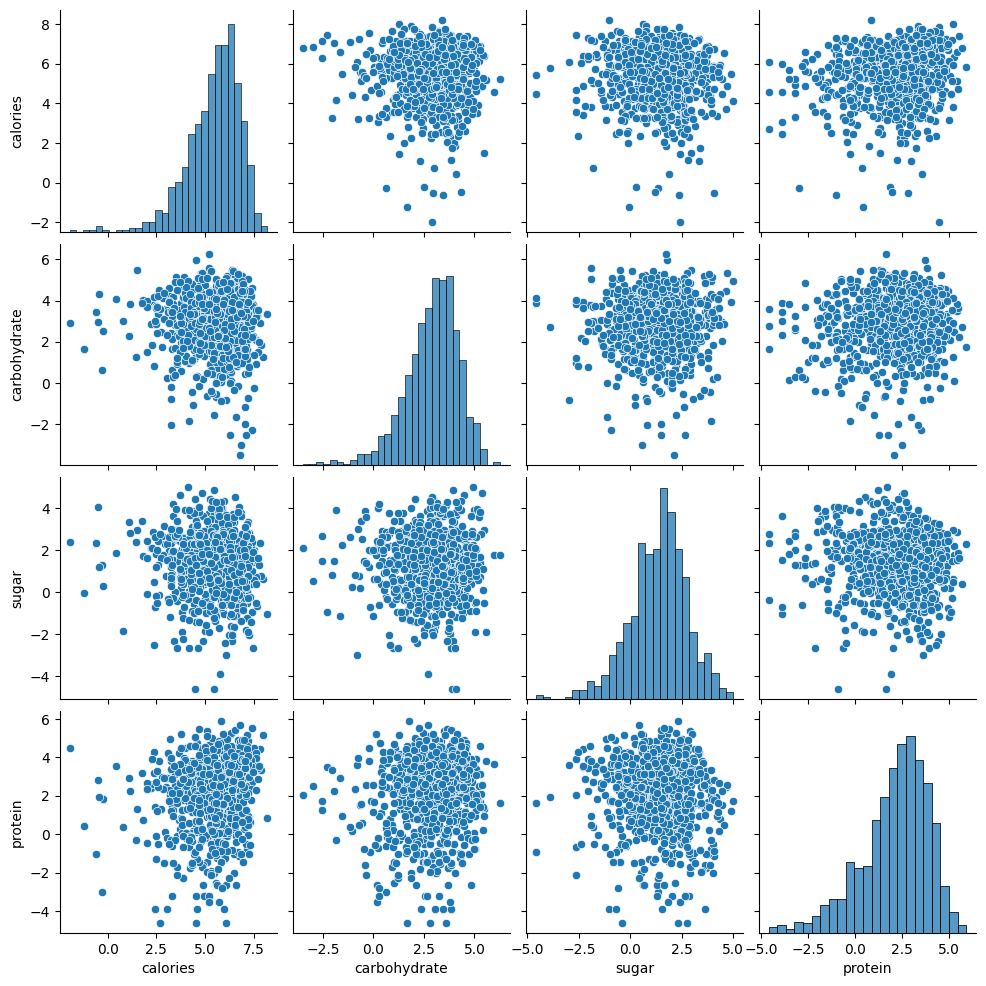

In [10]:
sns.pairplot(df_floats.apply(np.log))

## Cleaning the data

In [11]:
df_transformed = df.copy()

In [12]:
# Splitting the Lunch/Snacks category into Lunch and Snack
df_transformed['category'] = df.apply(lambda row: 'Snack' if 'snack' in row['servings'] else ('Lunch' if row['category'] == 'Lunch/Snacks' else row['category']), axis=1).astype('category')
df_transformed['category'].unique()

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', ..., 'Chicken', 'Vegetable', 'Meat', 'Dessert', 'Snack']
Length: 12
Categories (12, object): ['Beverages', 'Breakfast', 'Chicken', 'Chicken Breast', ..., 'Pork', 'Potato', 'Snack', 'Vegetable']

In [13]:
# Extracting the number of servings from the servings column
df_transformed['servings'] = df['servings'].apply(lambda v: v[0]).astype('int32')
df_transformed['servings'].unique()

array([6, 4, 1, 2], dtype=int32)

In [14]:
# Mapping the high_traffic column to boolean values
df_transformed['high_traffic'] = df['high_traffic'].apply(lambda v: 1 if v == 'High' else 0).astype('bool')
df_transformed['high_traffic'].unique()

array([ True, False])

## Plotting the high traffic

high_traffic
Yes    0.606125
No     0.393875
Name: proportion, dtype: float64


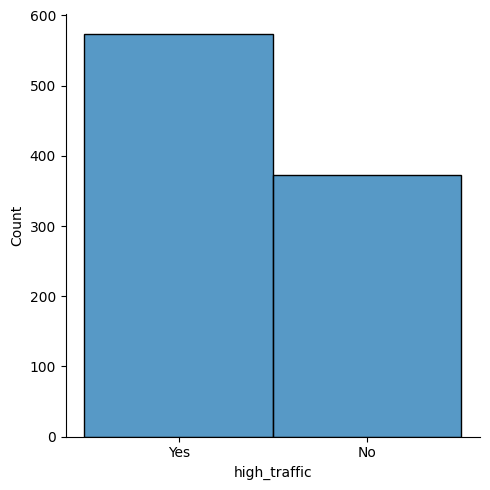

In [15]:
col_high_traffic = df_transformed['high_traffic'].map({False: 'No', True: 'Yes'})
print(col_high_traffic.value_counts(normalize=True))
sns.displot(col_high_traffic)

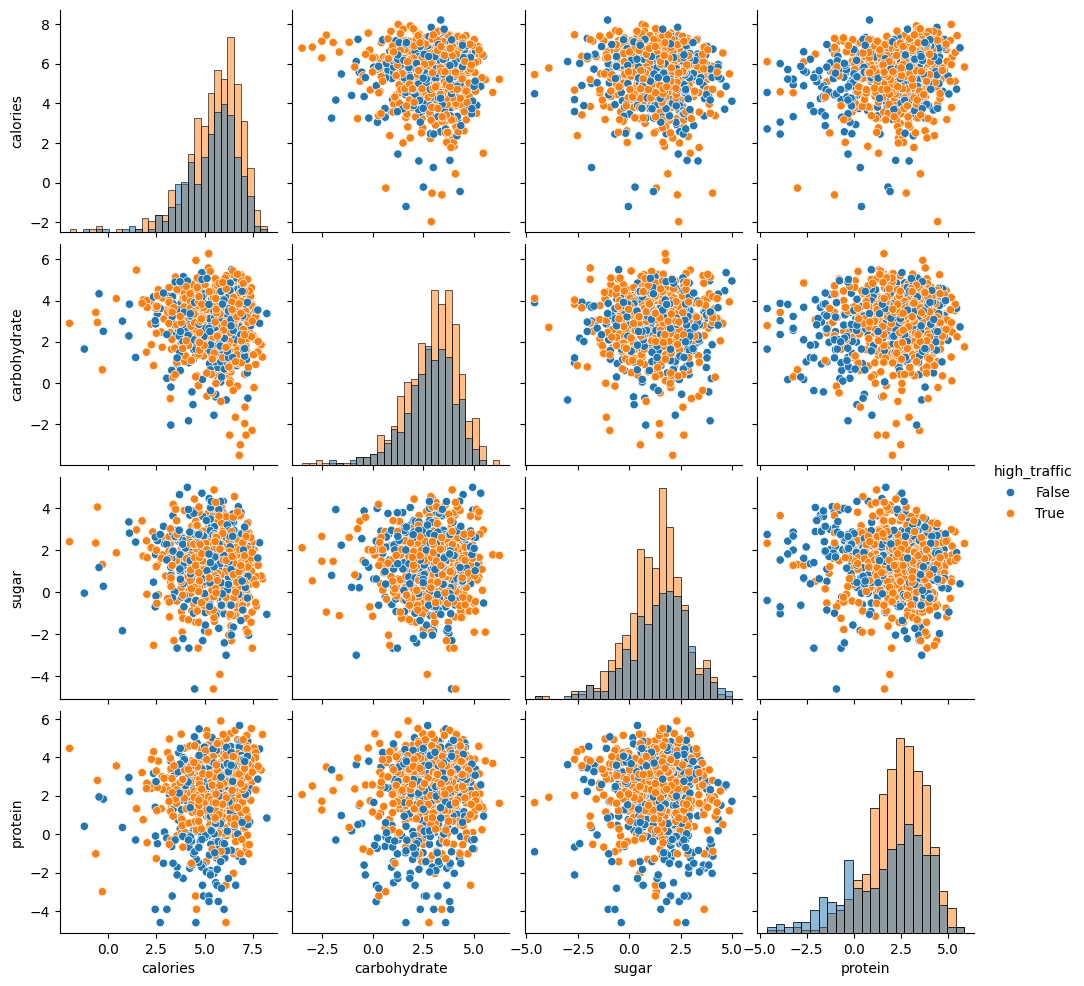

In [16]:
sns.pairplot(pd.concat([df_transformed['high_traffic'], df_floats.apply(np.log)], axis=1), hue='high_traffic', diag_kind='hist')

<Axes: xlabel='servings', ylabel='Count'>

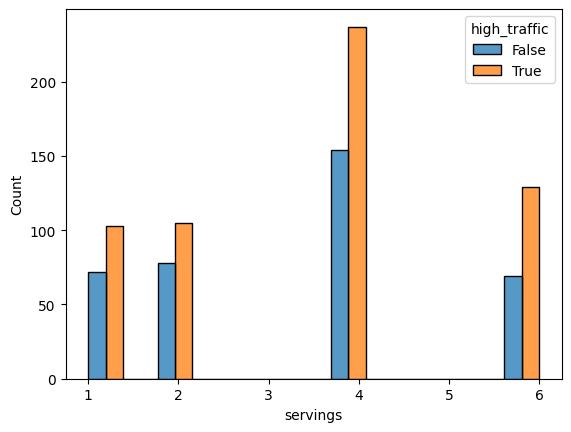

In [17]:
sns.histplot(df_transformed, x='servings', hue='high_traffic', multiple='dodge')

In [18]:
# Due to unbalanced classes, chi-squared test is performed
# Create a contingency table
contingency_table = pd.crosstab(df_transformed['servings'], df_transformed['high_traffic'])

# chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")

# Results
alpha = 0.05  # Significance level
if p < alpha:
    print("We reject the null hypothesis: 'servings' significantly affects 'high_traffic'.")
else:
    print("We fail to reject the null hypothesis: 'servings' does not significantly affect 'high_traffic'.")

Chi-Square Statistic: 2.7370
P-Value: 0.4340
We fail to reject the null hypothesis: 'servings' does not significantly affect 'high_traffic'.


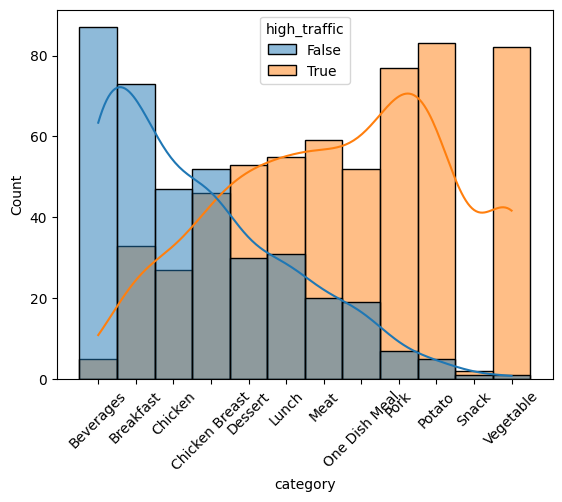

In [19]:
sns.histplot(df_transformed, x='category', hue='high_traffic', kde=True)
plt.xticks(rotation=45,)
plt.show()

In [20]:
pd.crosstab(df_transformed['category'], df_transformed['high_traffic'], normalize='index').sort_values(by=True, ascending=False)

high_traffic,False,True
category,,
Vegetable,0.012048,0.987952
Potato,0.056818,0.943182
Pork,0.083333,0.916667
Meat,0.253165,0.746835
One Dish Meal,0.267606,0.732394
Snack,0.333333,0.666667
Lunch,0.360465,0.639535
Dessert,0.361446,0.638554
Chicken Breast,0.530612,0.469388


### 🔍 Observations:
- Plotting high_traffic with the numeric features does not conclude with strong relationship -> futher conclusions might yet to come after fitting ML
- Plotting high_traffic with servings, also does not explain any high_traffic (remember that those classes are not balanced). After running chi2_contigency test it only futher proves that we fail to reject the null hypothesis, so the servings does not affect high_traffic significantly -> futher conclusions might yet to come after fitting ML
- Plotting high_traffic with category on the other hand shows strong relationship that some categories have higher interest than the other (highest interest: Vegetable, Potato, Pork all of them have above 90% high traffic) -> to be explored more

# Machine Learning

## Preprocessing

In [21]:
X = df_transformed.drop(columns=['high_traffic'], axis=1)
y = df_transformed['high_traffic'].values

num_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
cat_cols = ['category']
ser_cols = ['servings']

### Exploring the Preprocessing Methods

Mean skewness of the mean imputed data and StandardScaler() scaler: 3.47249799046143
Mean skewness of the mean imputed data and PowerTransformer() scaler: -0.009385156053696466
Mean skewness of the median imputed data and StandardScaler() scaler: 3.495331722784139
Mean skewness of the median imputed data and PowerTransformer() scaler: -0.0021624728171068053


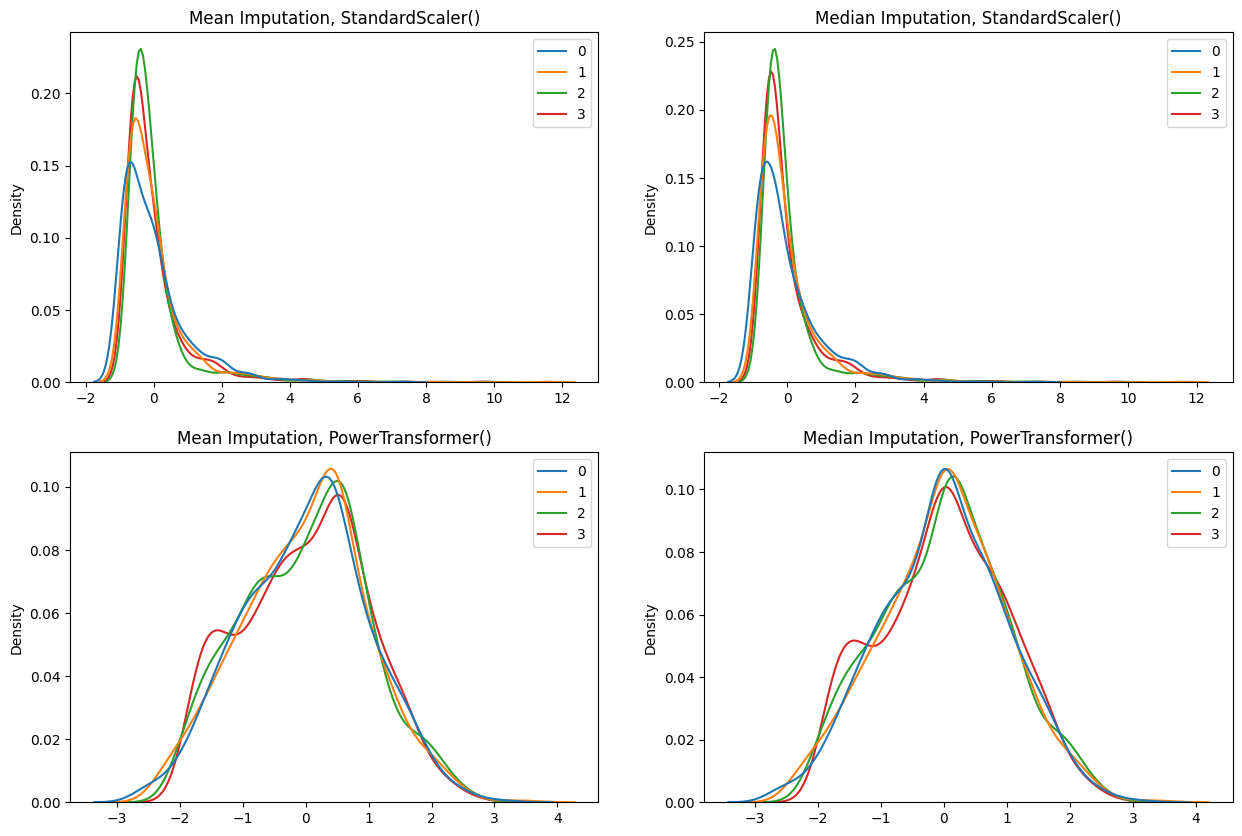

In [22]:
# Verify the shape of the numeric features
X_num = X.loc[:, num_cols]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for col, strategy in enumerate(['mean', 'median']):
    for row, scaler in enumerate([StandardScaler(), PowerTransformer()]):
        imputer = SimpleImputer(strategy=strategy)
        X_imputed = imputer.fit_transform(X_num)
        X_scaled = scaler.fit_transform(X_imputed)
        skewness = np.mean(skew(X_scaled))
        print(f'Mean skewness of the {strategy} imputed data and {scaler} scaler: {skewness}')
        sns.kdeplot(X_scaled, ax=axes[row, col])
        axes[row, col].set_title(f'{strategy.title()} Imputation, {scaler}')

plt.show()

In [23]:
# Verification of categorical columns			
X_cat = X.loc[:, cat_cols].astype('str')

X_cat = pd.get_dummies(X_cat)
X_cat

,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Snack,category_Vegetable
recipe,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
943,False,False,False,False,False,True,False,False,False,False,False,False
944,False,False,False,False,False,False,False,False,False,True,False,False
945,False,False,False,False,False,False,False,False,True,False,False,False


### Defining Preprocessing Steps

In [24]:
# Define preprocessing steps
preprocessor = ColumnTransformer([
    ('num', make_pipeline(SimpleImputer(strategy='median'), PowerTransformer()), num_cols),
    ('cat', OneHotEncoder(), cat_cols),
    ('ser', StandardScaler(), ser_cols)
])

### ✅ Decisions:
- PowerTransformer is used to reduce the skewness of the data
- Choosed strategy is median because of the lower skewness of the transformed data

## Model Definition

In [25]:
model_definition = {
    'logit': {
        'model': LogisticRegression(random_state=random_seed),
        'params': {
            'C': np.linspace(0.01, 1000, 5000),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'tree': {
        'model': DecisionTreeClassifier(random_state=random_seed),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_depth': [2, 5, 10, 15, 20, 25, 30],
            'min_samples_split': [2, 5, 8, 10, 13],
            'min_samples_leaf': [1, 2, 4, 8, 10]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(n_jobs=-1, random_state=random_seed),
        'params': {
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 10, 15, 20, 25, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    'adaboost': {
        'model': AdaBoostClassifier(random_state=random_seed),
        'params': {
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            'learning_rate': [.001, 0.01, .1, 1., 10.]
        }
    },
    'gradient_boost': {
        'model': GradientBoostingClassifier(random_state=random_seed),
        'params': {
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            'max_depth': [2, 5, 10, 15, 20, 25, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'learning_rate': [.001, 0.01, .1, 1., 10.]
        }
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(0, -50, num=5000)
        }
    },
    'svc': {
        'model': SVC(max_iter=-1, random_state=random_seed),
        'params': {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf', 'poly', 'sigmoid']
        }
    }
}


In [26]:
# Task is to get minimize the chance of showing unpopular recipes (maximize precision)
# while retaining prediction of 80% of popular recipes (recall)
# hence creation of custom scorer
def custom_precision_recall_scorer(y_true, y_pred):
    """Calculate precision and recall"""
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Check if recall is at least 80%
    if recall >= 0.8:
        return precision  # Return precision if recall is sufficient
    else:
        return 0

scorer = make_scorer(custom_precision_recall_scorer, greater_is_better=True)

## Model Evaluation

In [27]:
# train_test_split so the data can be used for further evaluation 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_seed,
    shuffle=True,
    stratify=y,
    test_size=.1
)

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
cv_results = {}

for model_name, model_info in model_definition.items():
    print(f"Training {model_name} model...")
    start = time()
    model, params = model_info['model'], model_info['params']
    
    params = {f'model__{k}': v for k, v in params.items()}
    
    steps = [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
    pipeline = Pipeline(steps)
    
    cv_model = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        cv=kf,
        n_iter=25,
        scoring=scorer,
        n_jobs=-1,
        random_state=random_seed,
        return_train_score=True
    )
    cv_model.fit(X_train, y_train)
    cv_results[model_name] = {
        'cv_model': cv_model,
        'results': cv_model.cv_results_,
        'best_score': cv_model.best_score_,
        'best_params': cv_model.best_params_
    }
    
    print(f"Training {model_name} model took {time()-start:.2f} seconds.")
    print(f"Best score: {cv_model.best_score_:.4f}")
    print(f"Best parameters: {cv_model.best_params_}")
    print("---")

Training logit model...
Training logit model took 2.90 seconds.
Best score: 0.5160
Best parameters: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 727.1481576315263}
---
Training tree model...
Training tree model took 0.35 seconds.
Best score: 0.7158
Best parameters: {'model__splitter': 'best', 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 2, 'model__criterion': 'entropy'}
---
Training random_forest model...
Training random_forest model took 5.01 seconds.
Best score: 0.7637
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 25, 'model__bootstrap': True}
---
Training adaboost model...
Training adaboost model took 4.64 seconds.
Best score: 0.7660
Best parameters: {'model__n_estimators': 10, 'model__learning_rate': 1.0}
---
Training gradient_boost model...
Training gradient_boost model took 6.89 seconds.
Best score: 0.7361
Best parameters: {'model__n_estimato

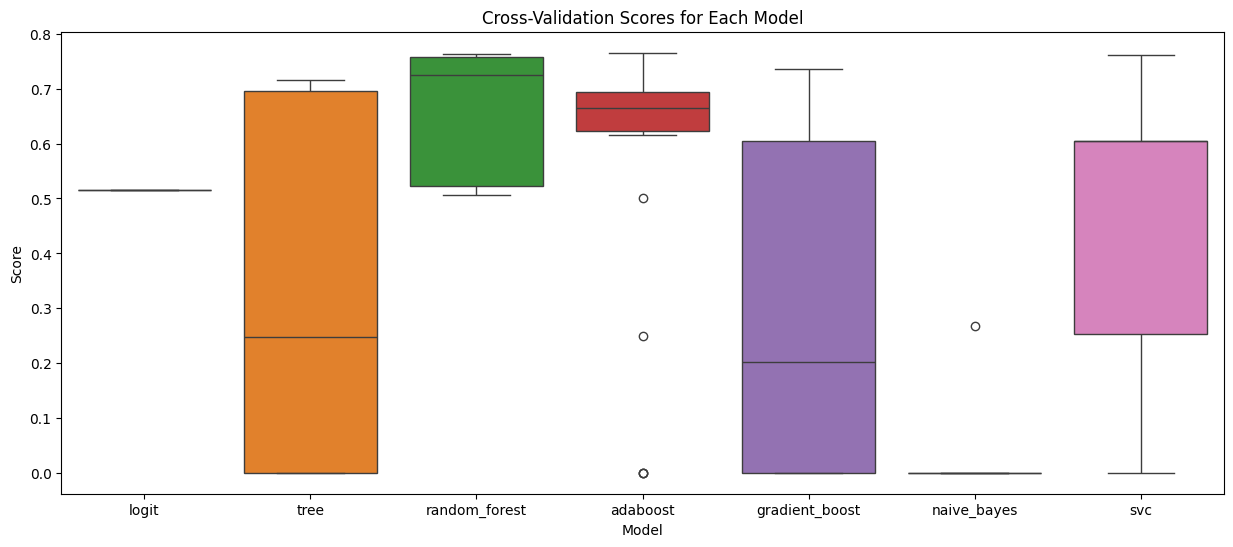

In [28]:
# Extract cross-validation scores for each model
cv_scores = {model_name: cv_results[model_name]['results']['mean_test_score'] for model_name in cv_results}

# Convert the scores to a DataFrame for easier plotting
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df.head()
# Plot the box plot
plt.figure(figsize=(15, 6))
sns.boxplot(data=cv_scores_df)
plt.title('Cross-Validation Scores for Each Model')
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()

### ✅ Decisions:
- Further evaluate 3 best performing models:
    - Random Forest Classifier
    - Decision Tree Classifier
    - Gradient Boosting Classifier
- Find the best performing one based on multiple metrics and retrieve business insights with it

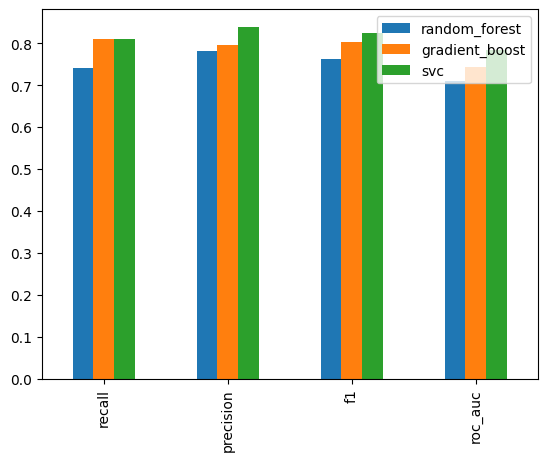

In [29]:
eval = {}
for model in ['random_forest', 'gradient_boost', 'svc']:
    y_pred = cv_results[model]['cv_model'].predict(X_test)
    eval[model] = [
        recall_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred)
    ]

eval_df = pd.DataFrame(eval, index=['recall', 'precision', 'f1', 'roc_auc'])
eval_df.plot(kind='bar')
plt.show()

### 🔍 Observations:
- Random Forest Classifier gets good precision but low AUC and on the test data it failed to deliver 80% recall
- Gradient Boosting Classifier model seems to have one of best recall scores, but significantly looses when it comes to precision and AUC
- SVC got the best precision of almost 84%, while retaining over 81% recall. This results in best F1 Score of all models - 82.5%. Moreover got the greatest AUC score of all models at 78.3%
### ✅ Decisions:
- SVC has been chosen as the model to compile business summary

In [30]:
print('SVC Scores:')
eval_df['svc']

SVC Scores:


recall       0.810345
precision    0.839286
f1           0.824561
roc_auc      0.783551
Name: svc, dtype: float64

# Business Summary

In [31]:
svc_pipeline = cv_results['svc']['cv_model'].best_estimator_
X_svc_transformed = svc_pipeline['preprocessor'].fit_transform(X_train)
feature_names = [str(i[5:]).replace('_', ' - ').title() for i in svc_pipeline['preprocessor'].get_feature_names_out()]
svc_model = svc_pipeline['model']

In [32]:
# Permutation importance
result = permutation_importance(svc_model, X_svc_transformed, y_train, n_repeats=10, random_state=random_seed)

for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {feature_names[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

Feature Category - Beverages: 0.092 +/- 0.005
Feature Category - Breakfast: 0.068 +/- 0.005
Feature Category - Chicken: 0.026 +/- 0.005
Feature Category - Chicken Breast: 0.017 +/- 0.002
Feature Sugar: 0.012 +/- 0.002
Feature Carbohydrate: 0.012 +/- 0.005
Feature Servings: 0.012 +/- 0.003
Feature Calories: 0.011 +/- 0.005
Feature Protein: 0.010 +/- 0.003
Feature Category - Vegetable: 0.002 +/- 0.004
Feature Category - Potato: 0.002 +/- 0.005
Feature Category - Meat: 0.001 +/- 0.002
Feature Category - Pork: 0.001 +/- 0.004
Feature Category - One Dish Meal: 0.000 +/- 0.002
Feature Category - Snack: 0.000 +/- 0.000
Feature Category - Dessert: -0.000 +/- 0.003
Feature Category - Lunch: -0.001 +/- 0.004


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'Category - Beverages'),
  Text(1, 0, 'Category - Breakfast'),
  Text(2, 0, 'Category - Chicken'),
  Text(3, 0, 'Category - Chicken Breast'),
  Text(4, 0, 'Sugar'),
  Text(5, 0, 'Carbohydrate'),
  Text(6, 0, 'Servings'),
  Text(7, 0, 'Calories'),
  Text(8, 0, 'Protein'),
  Text(9, 0, 'Category - Vegetable'),
  Text(10, 0, 'Category - Potato'),
  Text(11, 0, 'Category - Meat'),
  Text(12, 0, 'Category - Pork'),
  Text(13, 0, 'Category - One Dish Meal'),
  Text(14, 0, 'Category - Snack'),
  Text(15, 0, 'Category - Dessert'),
  Text(16, 0, 'Category - Lunch')])

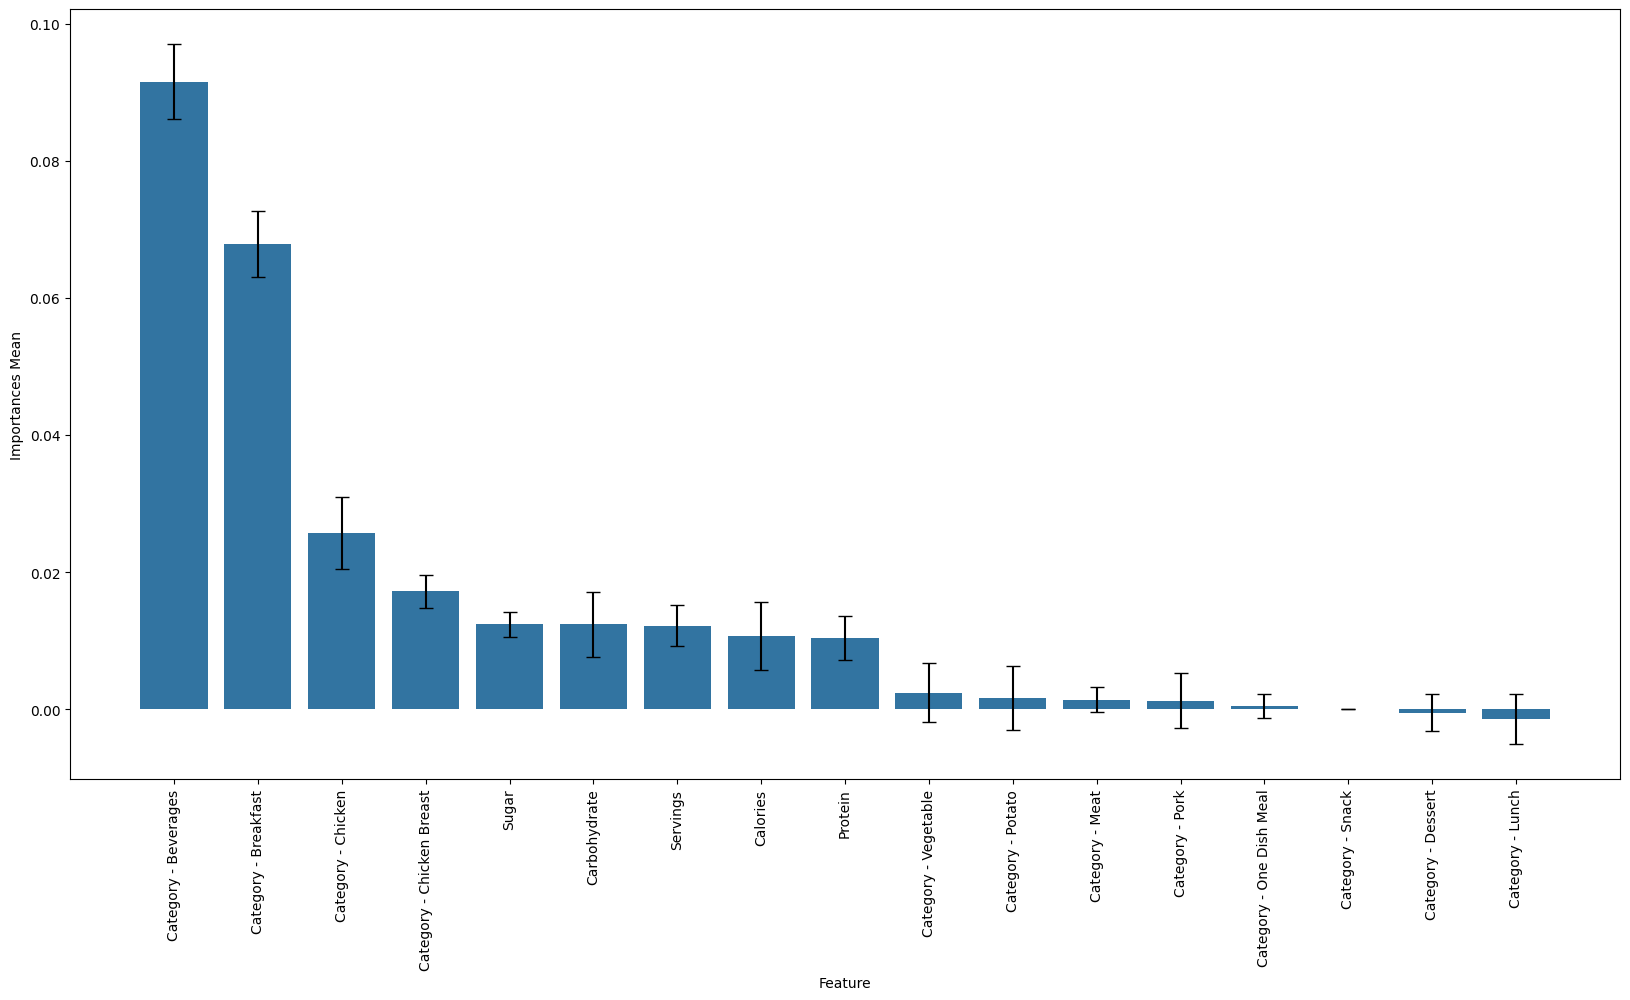

In [33]:
permutation_results_df = pd.DataFrame({
    'Feature': feature_names,
    'Importances Mean': result.importances_mean,
    'Importances Std': result.importances_std
    }
).sort_values('Importances Mean', ascending=False).reset_index()

plt.figure(figsize=(20,10))
sns.barplot(
    data=permutation_results_df,
    x='Feature',
    y='Importances Mean'
)

for index, row in permutation_results_df.iterrows():
    plt.errorbar(x=index, y=row['Importances Mean'], 
                 yerr=[[row['Importances Std']], [row['Importances Std']]], 
                 fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

PermutationExplainer explainer: 853it [06:47,  2.05it/s]                         


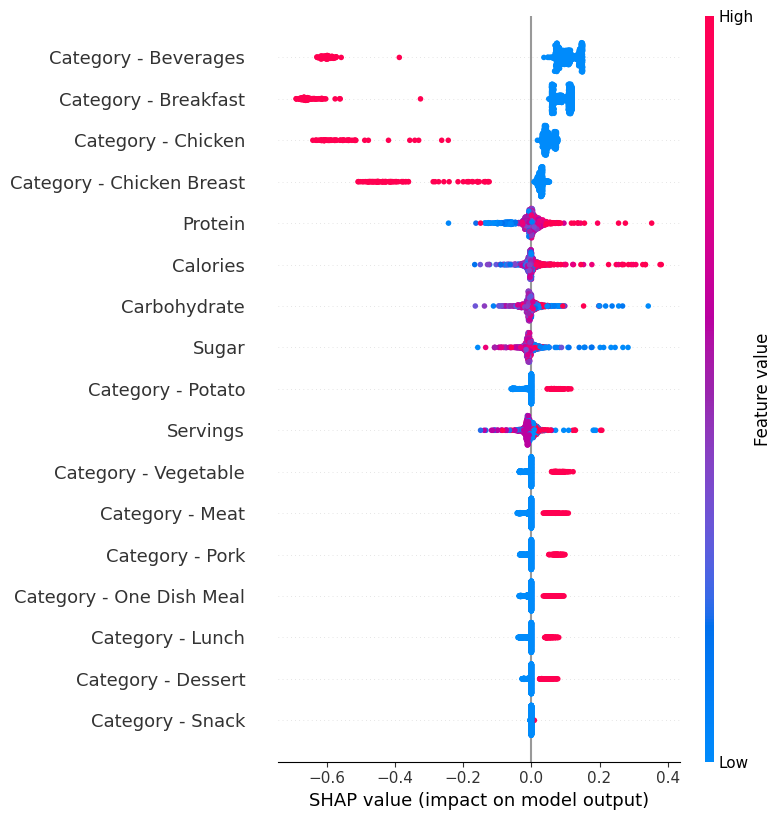

In [34]:
# SHAP Values that will help understand the model better 
# on what features drive the prediction and what direction

explainer = shap.Explainer(
    svc_model.predict,
    X_svc_transformed,
    feature_names=feature_names,
    seed=random_seed
)

shap_values = explainer(X_svc_transformed)

shap.summary_plot(shap_values, X_svc_transformed)


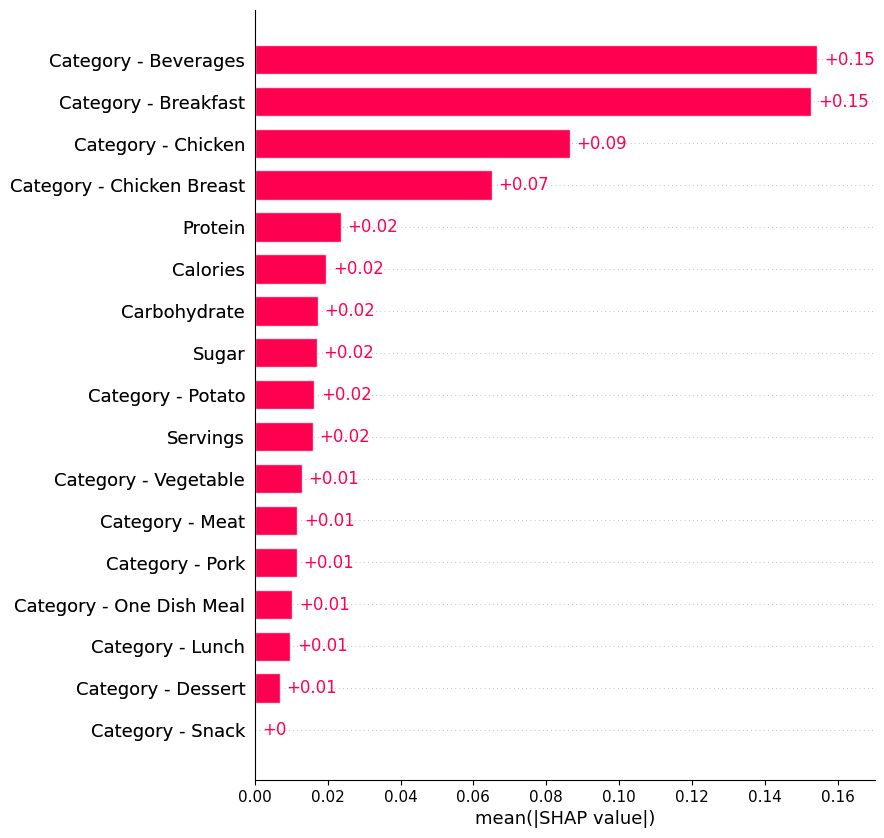

In [35]:
shap.plots.bar(shap_values, max_display=17)

In [36]:
# Get indices of support vectors
support_indices = svc_model.support_

# Retrieve original data for those support vectors
support_vector_data = X_train.iloc[support_indices]
support_vector_data['traffic'] = y_train[support_indices]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
# Filter support_indices to only include those present in X_train
valid_support_indices = [idx for idx in support_indices if idx in X_train.index]

# Get non-support vector data
non_support_data = X_train[~X_train.index.isin(valid_support_indices)]
non_support_data['traffic'] = y_train[~np.isin(X_train.index, valid_support_indices)]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


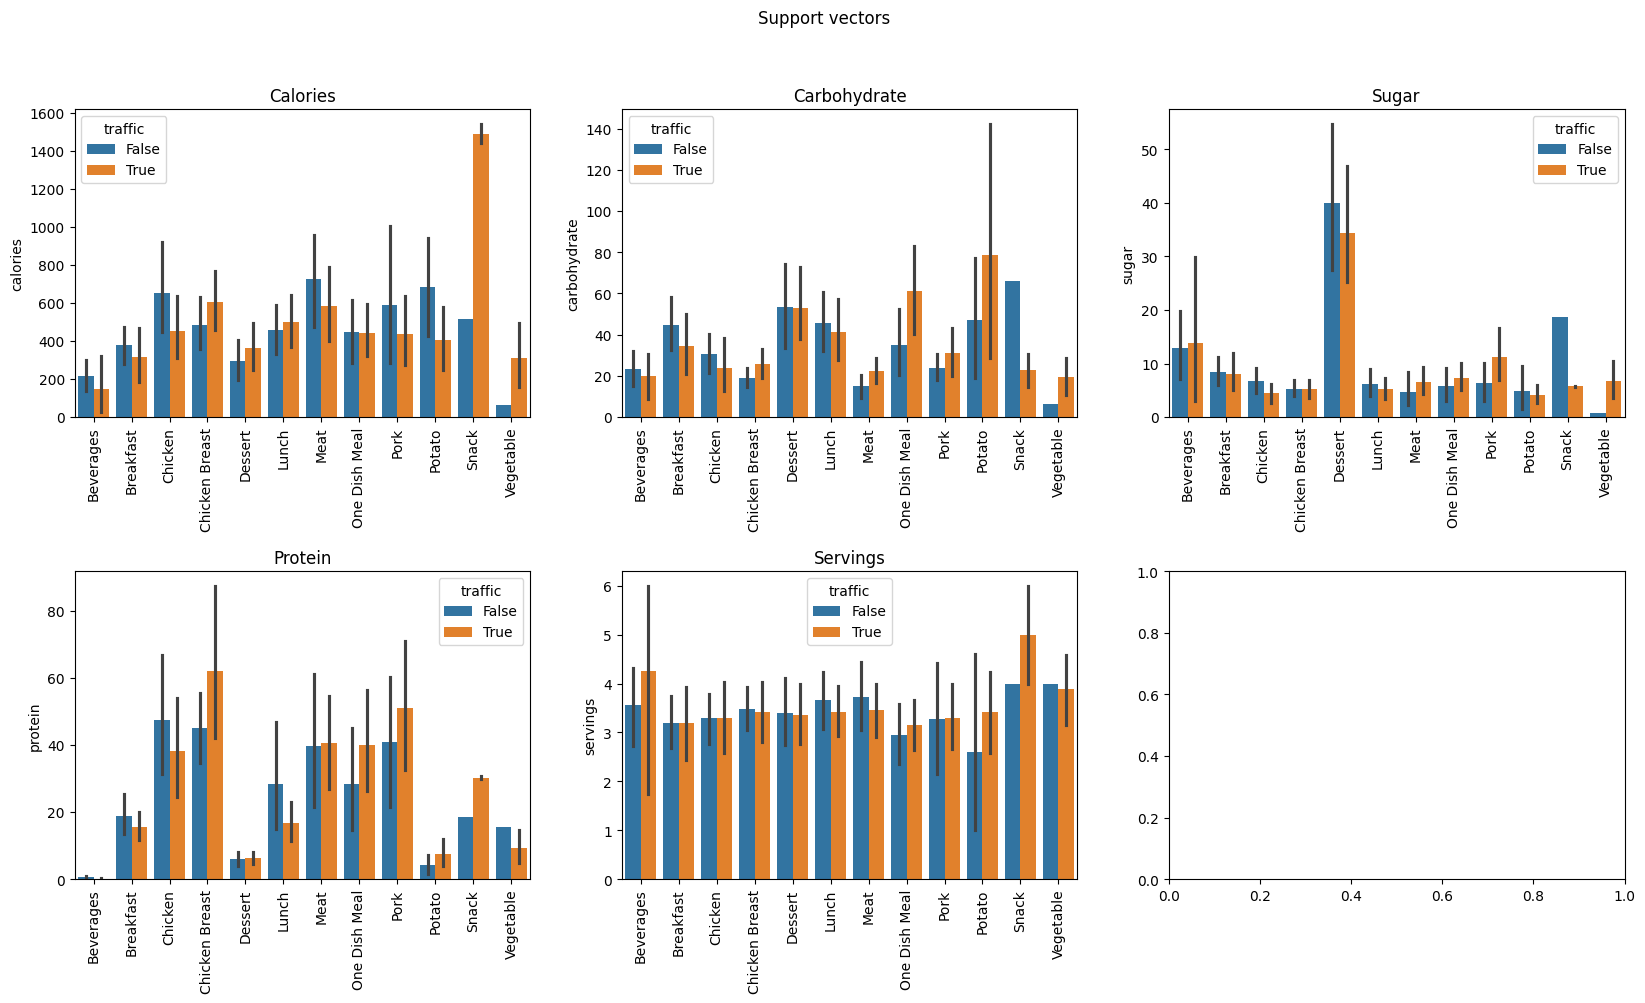

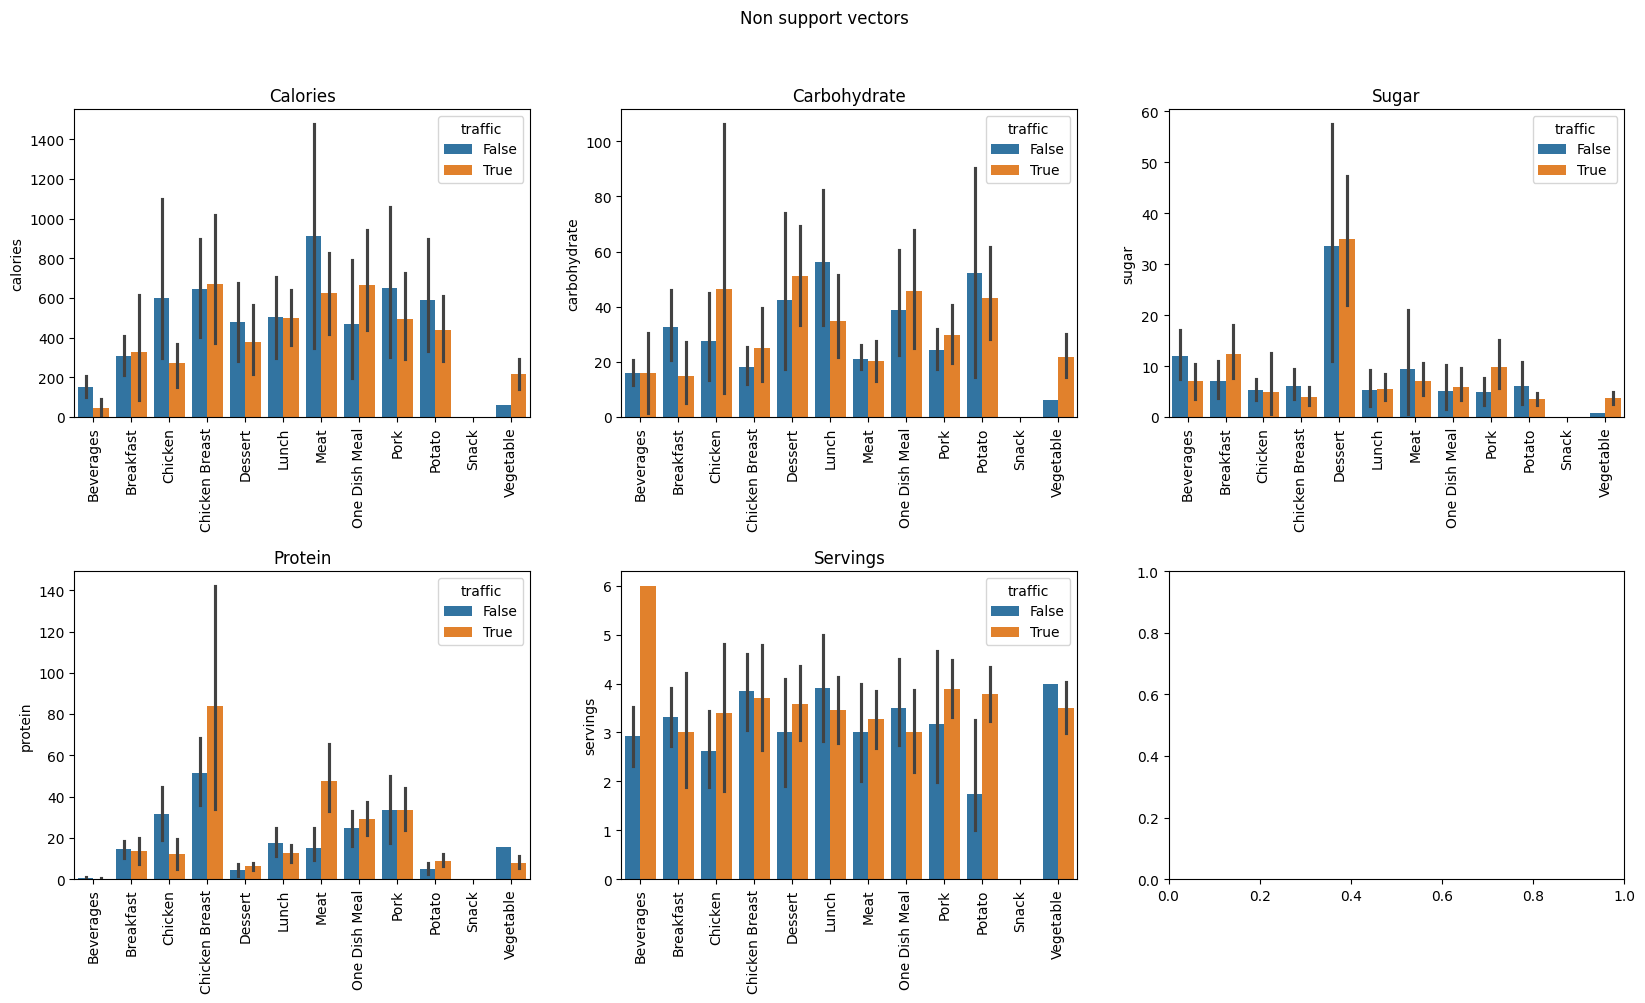

In [38]:
# Plot pairs of categories and numeric features for both support and non-support indices
for title, svc_df in [('Support vectors', support_vector_data), ('Non support vectors', non_support_data)]:
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5) 
    fig.suptitle(title)
    for i, category in enumerate(num_cols + ['servings']):
        row, col = i//3, i%3
        sns.barplot(svc_df, x='category', y=category, hue='traffic', ax=axes[row, col])
        axes[row, col].set_title(f'{category.title()}')
        axes[row, col].set_xlabel('')
        axes[row, col].tick_params(axis='x', rotation=90)
    plt.show()


## Conclusion

Based on the output of the machine learning model, we can derive that the highest impact on high traffic is the **category** of the recipes, influencing traffic in both positive and negative directions depending on the category. Calculating the SHAP values helped identify which features drive high traffic. The categories with the highest impact were identified through this analysis.

- The analysis revealed significant connections between features and high traffic on the recipe site.
- SHAP values analysis provided insights into feature importance and their impact direction:
    - The **category** feature had the highest SHAP values, indicating its strong influence on the traffic.
    - **Beverages**, **Breakfast**, and **Chicken**: Recipes in these categories tend to drive low traffic, as indicated by their negative SHAP values. 
    - **Calories content** and **protein content** also showed significant SHAP values, highlighting their roles in driving traffic. The analysis shows that **higher** values tend to drive traffic higher.
    - **Carbohydrate content** and **sugar content** also showed significant SHAP values, highlighting their roles in driving traffic. The analysis shows that **lower** values tend to drive traffic higher.
- The **category** of recipes emerged as the most influential feature, with certain categories like **Vegetable**, **Potato** and **Pork** showing over 90% high traffic.
- The SVM model effectively delineated the decision boundaries, highlighting the importance of specific features:
    - **Snack** alone does not drive the traffic, important are other features that correlate with this category, espacially high **calories** and low **carbohydrate** and **sugar**.
    - Even though, **Beverages** drive low traffic overall, there might be some potential hidden with **Beverages** with high **servings** and low **calories**.
- Significant pairs of category and numeric features were identified:
    - **Potato** with high carbohydrate content.
    - **Vegetable** with low sugar content.

### Feature Impact Direction
- **Category**: Categories like **Vegetable**, **Potato** and **Pork** drive high traffic positively, while categories like **Beverages**, **Chicken** and **Breakfast** drive traffic negatively.
- **Carbohydrate Content**: Higher carbohydrate content in categories like **Potato** positively influences high traffic.
- **Sugar Content**: Higher sugar content in categories like **Vegetable** positively influences high traffic.
- **Protein Content**: Higher protein content in certain categories can positively influence high traffic.
- **Calories Content**: Higher calories content tends to drive higher traffic, especially in categories like **Snack** or **Vegetable**.

### ⚠️ Disclaimer
- Each case should be analyzed individually to understand the nuances of feature interactions.
- It is crucial to remember that these are correlations, not causations, and further experimentation may be required to validate these conclusions.

## Key Performance Indicators (KPIs)
- **Model Precision**: This means that when our model predicts a recipe will be popular, it is correct 84% of the time. High precision ensures that we are not falsely identifying unpopular recipes as popular.
- **Model Recall**: This indicates that our model correctly identifies 81% of the truly popular recipes. High recall ensures that we are capturing most of the popular recipes.
- **F1 Score**: This is a balance between precision and recall, and our score of 82.5% indicates a good overall performance of the model in identifying popular recipes.
- **ROC AUC Score**: This score of 78.3% measures the model's ability to distinguish between popular and unpopular recipes. A higher score means better differentiation, helping us focus on promoting the right recipes.

## Recommendations
- Focus on promoting recipes in high-traffic categories such as **Vegetable**, **Potato** and **Pork**.
- Highlight nutritional content, especially **carbohydrate** and **protein** levels, in recipes to attract more traffic.
- Conduct further experiments to validate these findings and explore additional features that may influence traffic.
- With category **Beverages** avoid high **calories** and promote high **servings**
- Experiment on category **Snack**, there might be some hidden potential with high **calories** or high **protein** snacks.
- On **Potato** recipes focus on those with a high **servings**.

### Measures to Monitor
- **User Engagement**: Monitor user interactions (views, likes, shares) with recipes in high-traffic categories. Benchmark: 50% increase in user interactions for high-traffic categories.
- **Conversion Rate**: Calculate the conversion rate of users who view recipes to those who try or save them. Benchmark: 20% conversion rate.
- **User Feedback**: Collect and analyze user feedback on recipes to identify areas for improvement and new opportunities. Benchmark: 80% positive feedback.
- **Revenue Impact**: Assess the impact of high-traffic recipes on overall revenue and profitability. Benchmark: 25% increase in revenue from high-traffic recipes.
